In [20]:
import itertools as it

import torch
from torchvision import models as tvmodels
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from google.colab import files

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [1]:
def get_gpu_mem() -> int:
    return torch.cuda.memory_allocated() / (1024**2)


def clear_gpu_cache():
    torch.cuda.empty_cache()


def eval(model, input, use_grad=False):
    model.eval()
    start = get_gpu_mem()
    with torch.set_grad_enabled(use_grad):
        res = model(input)
    end = get_gpu_mem()
    diff = end - start
    print(f"After evaluation with use_grad: {use_grad} {end} diff {diff}")
    return diff


def compare_same_model(model_builder, weights, dummy_input):
    print("-" * 15)
    print(f"Model: {model_builder.__name__}, GPU usage: {get_gpu_mem()}")

    clear_gpu_cache()
    weights = weights.DEFAULT
    model = model_builder(weights=weights).to(device)
    print(f"{model_builder.__name__} sent to GPU, usage: {get_gpu_mem()}")
    dummy_input = weights.transforms()(dummy_input)
    print(f"Preproc input, GPU: {get_gpu_mem()}")
    mem_nograd = eval(model, dummy_input)
    print(f"GPU usage after NO GRAD: {get_gpu_mem()}")

    clear_gpu_cache()  # previous experiments show this is not needed actually
    mem_grad = eval(model, dummy_input, use_grad=True)
    print(f"GPU usage after GRAD: {get_gpu_mem()}")
    return [
        {"name": model_builder.__name__, "GPU_memory": mem_nograd, "grad": False},
        {"name": model_builder.__name__, "GPU_memory": mem_grad, "grad": True},
    ]

In [2]:
models = [
    tvmodels.vgg11,
    tvmodels.vgg11_bn,
    tvmodels.resnet18,
    tvmodels.resnet34,
    tvmodels.densenet121,
    tvmodels.mobilenet_v3_small,
]

pretrained_weights = [
    tvmodels.VGG11_Weights,
    tvmodels.VGG11_BN_Weights,
    tvmodels.ResNet18_Weights,
    tvmodels.ResNet34_Weights,
    tvmodels.DenseNet121_Weights,
    tvmodels.MobileNet_V3_Small_Weights,
]

In [3]:
print(f"Very start: {get_gpu_mem()}")

dummy_input = torch.rand(64, 3, 224, 224).to(device)
measures = []

init_gpu_mem = get_gpu_mem()
print(f"Input on GPU, memory: {init_gpu_mem}")

Very start: 0.0
Input on GPU, memory: 36.75


In [4]:
memory_measures = [compare_same_model(model_, w, dummy_input) for model_, w in zip(models, pretrained_weights)]

---------------
Model: vgg11, GPU usage: 36.75
vgg11 sent to GPU, usage: 544.083984375
Preproc input, GPU: 580.833984375
After evaluation with use_grad: False 581.078125 diff 0.244140625
GPU usage after NO GRAD: 580.833984375
After evaluation with use_grad: True 3523.078125 diff 2942.244140625
GPU usage after GRAD: 580.833984375
---------------
Model: vgg11_bn, GPU usage: 36.75
vgg11_bn sent to GPU, usage: 544.130859375
Preproc input, GPU: 580.880859375
After evaluation with use_grad: False 581.125 diff 0.244140625
GPU usage after NO GRAD: 580.880859375
After evaluation with use_grad: True 5336.125 diff 4755.244140625
GPU usage after GRAD: 580.880859375
---------------
Model: resnet18, GPU usage: 36.75
resnet18 sent to GPU, usage: 81.5654296875
Preproc input, GPU: 118.3154296875
After evaluation with use_grad: False 118.5595703125 diff 0.244140625
GPU usage after NO GRAD: 118.3154296875
After evaluation with use_grad: True 1437.5595703125 diff 1319.244140625
GPU usage after GRAD: 118.3

In [15]:
# QUESTION: resnet34 frees memory during a forward pass?! this why
# I'm taking the absolute value, but smth is wrong here

memory_df = pd.DataFrame(it.chain(*memory_measures))
memory_df["GPU_memory"] = np.abs(memory_df["GPU_memory"])
memory_df

,name,GPU_memory,grad
0,vgg11,0.244141,False
1,vgg11,2942.244141,True
2,vgg11_bn,0.244141,False
3,vgg11_bn,4755.244141,True
4,resnet18,0.244141,False
5,resnet18,1319.244141,True
6,resnet34,47.755859,False
7,resnet34,1931.744141,True
8,densenet121,0.244141,False
9,densenet121,7953.126953,True


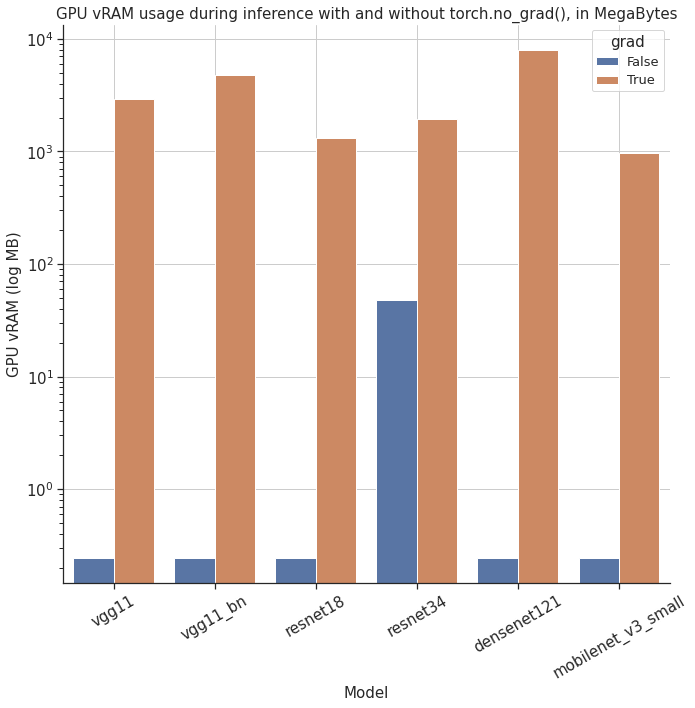

In [19]:
sns.set(style="ticks")

figsize = (10, 10)
fontsize = 15

fig, ax = plt.subplots(figsize=figsize)
sns.barplot(data=memory_df, x="name", y="GPU_memory", hue="grad", ax=ax)
ax.set_yscale("log")
ax.set_xlabel("Model", fontsize=fontsize)
ax.set_ylabel("GPU vRAM (log MB)", fontsize=fontsize)
ax.set_title("GPU vRAM usage during inference with and without torch.no_grad(), in MegaBytes", fontsize=fontsize)
ax.xaxis.set_tick_params(labelsize=fontsize)
ax.yaxis.set_tick_params(labelsize=fontsize)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
plt.setp(ax.get_legend().get_title(), fontsize=str(fontsize)) 
plt.setp(ax.get_legend().get_texts(), fontsize='13') 
ax.grid()
plt.tight_layout()

In [21]:
fname="gpu_vram_grad_comparison.png"
fig.savefig(fname)
files.download(fname) 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>